## Import

In [1]:
import random
import pandas as pd
import numpy as np
import os
import cv2
import time, datetime
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, f1_score, confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.distributed import DistributedSampler
import torchvision.models as models
from torch.cuda.amp import autocast, GradScaler

from tqdm.auto import tqdm
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2



import warnings
warnings.filterwarnings(action='ignore') 

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## Hyperparameter Setting

In [ ]:
CFG = {
    'fold_num': 5, # TRAIN:TEST SET 4:1
    'seed': 42,
    't_model': 'inception_resnet_v2', # TEACHER MODEL
    'load_model': 'inception_resnet_v2_20230421010009', # LOAD TEACHER MODEL
    's_model': 'mobilenetv2_100', # STUDENT MODEL
    'img_size': 260,
    'epochs': 100,
    'train_bs':128, ## train_ batch size
    'valid_bs':64,
    'T_0': 10,
    'lr': 1e-4,
    'min_lr': 1e-6,
    'num_workers': 0,
    'accum_iter': 2, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1,
    'patience' : 5,
    'device': 'cuda:0',
    'freezing': False,
    'model_path': '/content/drive/MyDrive/탄소저감프로젝트/models/test/'
}

In [ ]:
time_now = dt.datetime.now()
run_id = time_now.strftime("%Y%m%d%H%M%S")

#### Model Define

In [ ]:
# LOAD PRE-TRAINED MODEL
class BaseModel(nn.Module):
    def __init__(self, model_arch, num_classes= 2,pretrained=True):
        super(BaseModel, self).__init__()
        self.backbone = models.resnet50(pretrained=pretrained) ## 모델 선언 여기 models.##(pretrained =pretrained)
        self.classifier = nn.Linear(1000, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

## Fixed RandomSeed

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['seed']) # Seed 고정

## Data Pre-processing

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
main_path = '/content/drive/MyDrive/종프전사들/ecoce/'
img_paths = [] 

for folder, subfolders, filenames in os.walk(main_path): ## 폴더 내 모든 파일 탐색
    for img in filenames: ## 각 파일 경로, 레이블 저장
        img_paths.append(folder+'/'+img)
print(len(img_paths))

38274


In [ ]:
main_path = '/content/drive/MyDrive/종프전사들/ecoce/'
label_list = ["10kwalking","public_vehicle"]

total_train_img_paths = []
total_train_img_labels = []
total_test_img_paths = []
total_test_img_labels = []

for label in label_list: ## 각 레이블 돌기
    print(f'label: {label}')
    img_paths = [] 
    img_labels = []

    # default ratio
    train_ratio = 1000
    test_ratio = 400

    dir_path = main_path + label ## 레이블 폴더 경로
    count = 0
    for folder, subfolders, filenames in os.walk(dir_path): ## 폴더 내 모든 파일 탐색

    for img in filenames: ## 각 파일 경로, 레이블 저장
        count +=1
        if count > train_ratio + test_ratio:
        break

        img_paths.append(folder+'/'+img)
        img_labels.append(label)

    print(f'img_paths len : {len(img_paths)}\n')

    if label == '10kwalking': ## 10walking 데이터 비율 설정하기 (데이터수: 2494)
    train_ratio = 500
    test_ratio = 200
    elif label == 'public_vehicle': ## 10walking 데이터 비율 설정하기 (데이터수: 2494)
    train_ratio = 500
    test_ratio = 200

    total_train_img_paths.extend(img_paths[:train_ratio])
    total_train_img_labels.extend(img_labels[:train_ratio])

    total_test_img_paths.extend(img_paths[-test_ratio:])
    total_test_img_labels.extend(img_labels[-test_ratio:])

print('Train_Images: ',len(total_train_img_paths))
print("Train_Images_labels:", len(total_train_img_labels))
print('Test_Images: ',len(total_test_img_paths))
print("Test_Images_labels:", len(total_test_img_labels))

label: 10kwalking
img_paths len : 1400

label: public_vehicle
img_paths len : 1245

Train_Images:  1000
Train_Images_labels: 1000
Test_Images:  400
Test_Images_labels: 400


In [ ]:
## Pandas 데이터프레임 만들기
trn_df = pd.DataFrame(total_train_img_paths, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
trn_df['label'] = total_train_img_labels
train = trn_df
train

,image_id,dir,label
0,캐시워크 만보_352.jpg,/content/drive/MyDrive/탄소저감프로젝트/dat...,10kwalking
1,캐시워크 만보_354.jpg,/content/drive/MyDrive/탄소저감프로젝트/dat...,10kwalking
2,캐시워크 만보_355.jpg,/content/drive/MyDrive/탄소저감프로젝트/dat...,10kwalking
3,캐시워크 만보_353.jpg,/content/drive/MyDrive/탄소저감프로젝트/dat...,10kwalking
4,캐시워크 만보_356.jpg,/content/drive/MyDrive/탄소저감프로젝트/dat...,10kwalking
...,...,...,...
995,버스_387.jpg,/content/drive/MyDrive/탄소저감프로젝트/dat...,public_vehicle
996,버스_390.jpg,/content/drive/MyDrive/탄소저감프로젝트/dat...,public_vehicle
997,버스_391.jpg,/content/drive/MyDrive/탄소저감프로젝트/dat...,public_vehicle
998,버스_393.jpg,/content/drive/MyDrive/탄소저감프로젝트/dat...,public_vehicle


In [ ]:
# Label Encoding
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'].values)

In [ ]:
def get_img(path, train_arg=False, sub_path=None):
    try:
        im_bgr = cv2.imread(path)
        im_rgb = im_bgr[:, :, ::-1]
        past_path = path
    except: ## 이미지 에러 발생 시 백지로 대체
        im_bgr = cv2.imread('/content/drive/MyDrive/탄소저감프로젝트/temp_img.jpg')
        im_rgb = im_bgr[:, :, ::-1]
    if train_arg:
        dimg = cv2.fastNlMeansDenoisingColored(im_rgb, None, 10,10,7,21)
        return dimg
    else:
        return im_rgb

## CustomDataset

In [ ]:
class ColonDataset(Dataset):
    def __init__(self, df, data_root, train_arg=False,
                 transform=None,
                 output_label=True
                ):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.train_arg = train_arg
        self.transform = transform
        self.data_root = data_root
        self.output_label = output_label
        
        if output_label == True:
            self.labels = self.df['label'].values
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.labels[index]
        
        img  = get_img("{}/{}".format(self.data_root[index], self.df.loc[index]['image_id']), train_arg=self.train_arg)

        if self.transform:
            transformed = self.transform(image=img)
            img = transformed['image']
        
                
        if self.output_label == True:
            return img, target
        else:
            return img

## Data Load

In [ ]:
## Data Augmentation
transform_train = A.Compose(
    [
        A.RandomResizedCrop(p=1, height=CFG['img_size'] ,width=CFG['img_size'], scale=(0.65, 0.75),ratio=(0.90, 1.10)),
        A.SafeRotate(p=0.5, limit=(-20, 20), interpolation=2, border_mode=0, value=(0, 0, 0), mask_value=None),
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(always_apply=True, p=0.5, contrast=0.2, saturation=0.3, hue=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
        A.pytorch.transforms.ToTensorV2()
        ])

transform_test = A.Compose(
    [
        A.Resize(height = CFG['img_size'], width = CFG['img_size']),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
        A.pytorch.transforms.ToTensorV2()
        ])

In [ ]:
def prepare_dataloader(df, trn_idx, val_idx, data_root=train.dir.values):
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
    train_data_root = data_root[trn_idx]
    valid_data_root = data_root[val_idx]
    
        
    train_ds = ColonDataset(train_,
                            train_data_root,
                            transform=transform_train,
                            output_label=True)
    valid_ds = ColonDataset(valid_,
                            valid_data_root,
                            transform=transform_test,
                            output_label=True)
    

    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=True,
        drop_last=False,
        shuffle=True,        
        num_workers=CFG['num_workers']
        #sampler=DistributedSampler(train_ds)
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=True,
    )
    return train_loader, val_loader

In [ ]:
# F1 score용 EarlyStopping
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_valid_loss = None
        self.early_stop = False

    def __call__(self, loss):
        if self.best_valid_loss is None:
            self.best_valid_loss = loss
        elif loss > self.best_valid_loss:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            print(f'Best valid loss from now: {self.best_valid_loss}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_valid_loss = loss
            self.counter = 0
        
        return self.early_stop

#### DISTILLATION LOSS FROM TEACHER

In [ ]:
def distill_loss(student_logits, labels, teacher_logits, criterion, alpha=0.1, temperature=2):
    # STUDENT & LABEL LOSS
    student_loss = criterion(student_logits, labels)

    # TEACHER & STUDENT LOSS
    teacher_probs = F.softmax(teacher_logits / temperature, dim=1)
    student_probs = F.softmax(student_logits / temperature, dim=1)
    distillation_loss = F.kl_div(torch.log(student_probs), teacher_probs, reduction="batchmean") * (temperature ** 2)

    # FINAL LOSS
    loss_b = alpha * student_loss + (1 - alpha) * distillation_loss
    return loss_b


## Train

In [ ]:
def train_one_epoch(epoch, s_model, t_model, loss_tr, optimizer, train_loader, device, scheduler=None, alpha =0.1):
    t = time.time()

    # SET MODEL TRAINING MODE
    s_model.train()
    t_model.eval()
    
    running_loss = None
    loss_sum = 0
    student_preds_all = []
    image_targets_all = []
    acc_list = []
    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        optimizer.zero_grad()
        
         # STUDENT MODEL PREDICTION
        with torch.cuda.amp.autocast():
            student_preds = s_model(imgs)
            
            # TEACHER MODEL DISTILLATION (NO UPDATE)
            with torch.no_grad():
                teacher_preds = t_model(imgs)
                
            # DISTILLATION LOSS    
            loss = distill_loss(student_preds, image_labels, teacher_preds, loss_tr, alpha)
            loss_sum+=loss.detach()
            
            # BACKPROPAGATION
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01
            
            # TQDM VERBOSE_STEP TRACKING
            if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
                description = f'epoch {epoch} loss: {running_loss:.4f}'
                pbar.set_description(description)
            
        student_preds_all += [torch.argmax(student_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
    if scheduler is not None:
        scheduler.step()
        
    student_preds_all = np.concatenate(student_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    
    matrix = confusion_matrix(image_targets_all,student_preds_all)
    epoch_f1 = f1_score(image_targets_all, student_preds_all, average='macro')
    accuracy = (student_preds_all==image_targets_all).mean()
    trn_loss = loss_sum/len(train_loader)
    
    
    return student_preds_all, accuracy, trn_loss, matrix, epoch_f1

def valid_one_epoch(epoch,s_model, t_model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False, alpha =0.1):
    ## Sets the model to valid mode
    s_model.eval()
    t_model.eval()

    t = time.time()
    loss_sum = 0
    sample_num = 0
    avg_loss = 0
    student_preds_all = []
    image_targets_all = []
    
    acc_list = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        student_preds = s_model(imgs)   #output = model(input)
        teacher_preds = t_model(imgs) # teacher prediction
        
        loss = distill_loss(student_preds, image_labels, teacher_preds, loss_fn, alpha)
        
        student_preds_all += [torch.argmax(student_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        avg_loss += loss.item()
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]
        
        description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
        pbar.set_description(description)
    
    student_preds_all = np.concatenate(student_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    matrix = confusion_matrix(image_targets_all,student_preds_all)
    
    epoch_f1 = f1_score(image_targets_all, student_preds_all, average='macro')
    acc = (student_preds_all==image_targets_all).mean()
    val_loss = avg_loss/len(val_loader)
    
    return student_preds_all, acc, val_loss, matrix, epoch_f1

Training start with epoch 100 



Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 92.2MB/s]


  0%|          | 0/13 [00:00<?, ?it/s]

train accuracy = 0.75125
[[298 102]
 [ 97 303]]


  0%|          | 0/4 [00:00<?, ?it/s]

validation accuracy = 1.00000
[[100   0]
 [  0 100]]


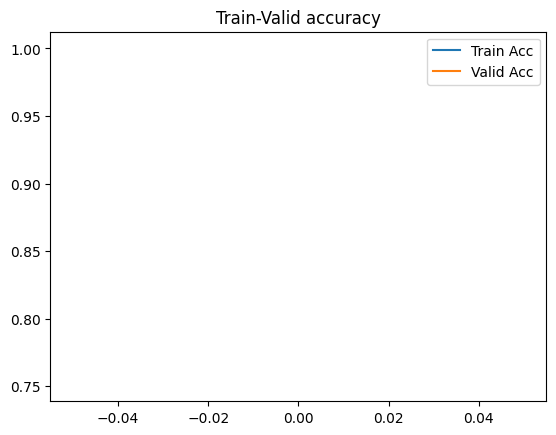

  0%|          | 0/13 [00:00<?, ?it/s]

train accuracy = 0.99625
[[399   1]
 [  2 398]]


  0%|          | 0/4 [00:00<?, ?it/s]

validation accuracy = 1.00000
[[100   0]
 [  0 100]]


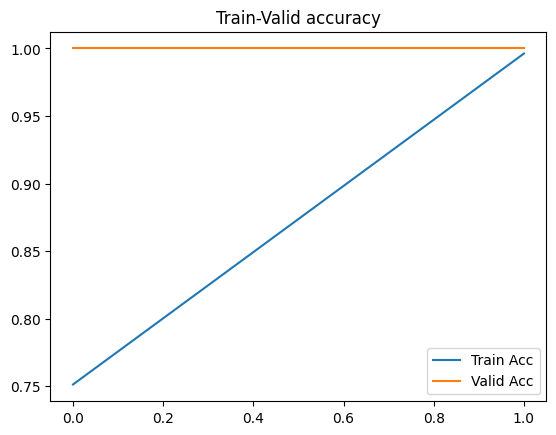

  0%|          | 0/13 [00:00<?, ?it/s]

train accuracy = 1.00000
[[400   0]
 [  0 400]]


  0%|          | 0/4 [00:00<?, ?it/s]

validation accuracy = 1.00000
[[100   0]
 [  0 100]]


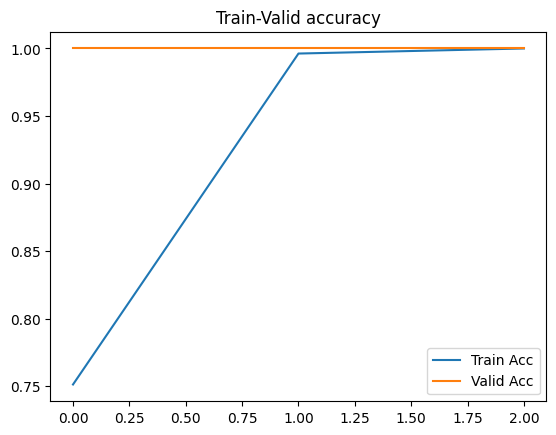

  0%|          | 0/13 [00:00<?, ?it/s]

train accuracy = 0.99875
[[400   0]
 [  1 399]]


  0%|          | 0/4 [00:00<?, ?it/s]

validation accuracy = 1.00000
[[100   0]
 [  0 100]]


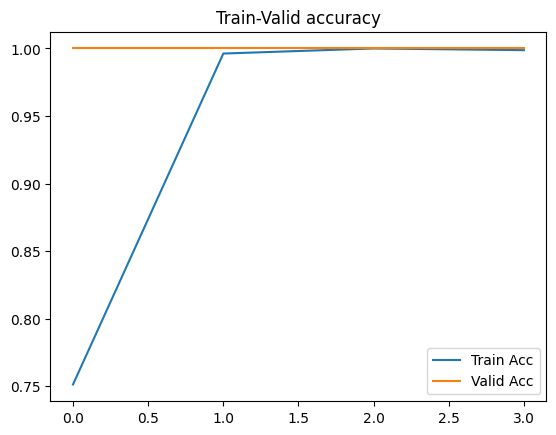

EarlyStopping counter: 1 out of 3
Best valid loss from now: 0.00017172243224194972


  0%|          | 0/13 [00:00<?, ?it/s]

train accuracy = 0.99875
[[399   1]
 [  0 400]]


  0%|          | 0/4 [00:00<?, ?it/s]

validation accuracy = 1.00000
[[100   0]
 [  0 100]]


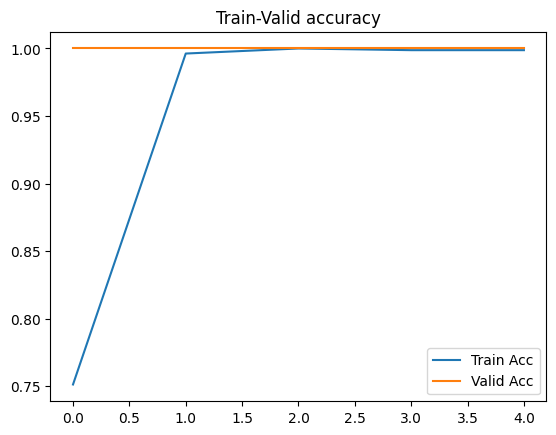

EarlyStopping counter: 2 out of 3
Best valid loss from now: 0.00017172243224194972


  0%|          | 0/13 [00:00<?, ?it/s]

train accuracy = 1.00000
[[400   0]
 [  0 400]]


  0%|          | 0/4 [00:00<?, ?it/s]

validation accuracy = 1.00000
[[100   0]
 [  0 100]]


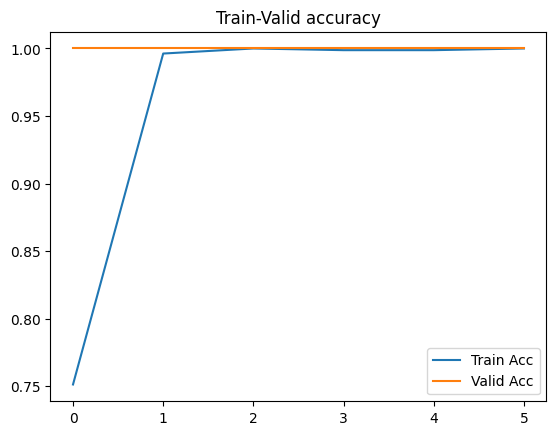

EarlyStopping counter: 3 out of 3
Best valid loss from now: 0.00017172243224194972
stop called
time : 0:06:27
Best Epoch : 0/ 6
Best Train Accuracy : 0.75125
[[298 102]
 [ 97 303]]
Best Valid Accuracy : 1.00000
[[100   0]
 [  0 100]]


In [ ]:
if __name__ == '__main__':
    
    model_dir = CFG['model_path'] + '/{}_{}'.format(CFG['s_model'], run_id)
    train_dir = train.dir.values
    best_accuracy =0.0
    
    seed_everything(CFG['seed'])
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)
    
    print('Model: {}'.format(CFG['s_model']))
    # MAKE MODEL DIR
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)
    
    # STRATIFIED K-FOLD DEFINITION
    folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)
    
    for fold, (trn_idx, val_idx) in enumerate(folds): ## K - FOLD 사용 하지 않음 Train : Validation 비율 나누기로 사용
        break
    
    print(f'Training start with epoch {CFG["epochs"]} \n')

    # EARLY STOPPING DEFINITION
    early_stopping = EarlyStopping(patience=CFG["patience"], verbose=True)
    
    # DATALOADER DEFINITION
    train_loader, val_loader = prepare_dataloader(train, trn_idx, val_idx, data_root=train_dir)
    
    # MODEL & DEVICE DEFINITION 
    device = torch.device(CFG['device'])
    student_model = BaseModel(CFG['model'], train.label.nunique(), pretrained=True).to(device)
    teacher_model = BaseModel(CFG['model'], train.label.nunique(), pretrained=True).to(device)
    
    # LOAD TEACHER_MODE WEIGHT
    load_model = CFG['load_model'] 
    teacher_model.load_state_dict(torch.load(load_model))
    
    
    scaler = GradScaler()   
    optimizer = torch.optim.Adam(student_model.parameters(), lr=CFG['lr'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=25)
    
    # DISTILLATION RATE
    alpha = CFG['alpha']
    
    # CRITERION (LOSS FUNCTION)
    loss_tr = nn.CrossEntropyLoss().to(device) 
    loss_fn = nn.CrossEntropyLoss().to(device)

    
    train_acc_list = []
    train_matrix_list = []
    valid_acc_list = []
    valid_matrix_list = []

    start = time.time()
    for epoch in range(CFG['epochs']):
        print('Epoch {}/{}'.format(epoch, CFG['epochs'] - 1))
        
        # TRAINIG
        train_preds_all, train_acc, train_loss, train_matrix, train_f1 = train_one_epoch(epoch, student_model, teacher_model,loss_tr, optimizer, train_loader, device, scheduler=scheduler, alpha = alpha)
        
        # VALIDATION
        with torch.no_grad():
            valid_preds_all, valid_acc, valid_loss, valid_matrix, valid_f1= valid_one_epoch(epoch, student_model, teacher_model, loss_fn, val_loader, device, scheduler=None, alpha = alpha)
        
        
        # MODEL SAVE (THE BEST MODEL)
        if valid_acc > best_accuracy:
                best_accuracy = valid_acc
                torch.save(model.state_dict(), (model_dir+'/{}').format(CFG['s_model']))


        # SAVE ALL RESULTS
        train_acc_list.append(train_acc)
        train_matrix_list.append(train_matrix)
        
        valid_acc_list.append(valid_acc)
        valid_matrix_list.append(valid_matrix)

         # EARLY STOPPING
        stop = early_stopping(valid_loss)
        if stop:
            print("stop called")   
            break

    fig = plt.figure().add_subplot(1, 1, 1)
    fig.plot(train_acc_list, label='Train Acc')
    fig.plot(valid_acc_list, label='Valid Acc')
    fig.set_title('Train-Valid accuracy')
    fig.legend()
    plt.show()
    
    end = time.time() - start
    time_ = str(datetime.timedelta(seconds=end)).split(".")[0]
    print("time :", time_)

    best_index = valid_acc_list.index(max(valid_acc_list))
    print(f'Best Epoch : {best_index}/ {len(valid_acc_list)}')
    print(f'Best Train Accuracy : {train_acc_list[best_index]:.5f}')
    print(train_matrix_list[best_index])
    print(f'Best Valid Accuracy : {valid_acc_list[best_index]:.5f}')
    print(valid_matrix_list[best_index])


## Inference

In [ ]:
## Pandas Test 데이터프레임 만들기
tst_df = pd.DataFrame(total_test_img_paths, columns=['image_id'])
tst_df['dir'] = tst_df['image_id'].apply(lambda x: os.path.dirname(x))
tst_df['image_id'] = tst_df['image_id'].apply(lambda x: os.path.basename(x))
tst_df['label'] = total_test_img_labels
test = tst_df
test

,image_id,dir,label
0,만보인증_439.jpg,/content/drive/MyDrive/탄소저감프로젝트/dat...,10kwalking
1,만보인증_441.jpg,/content/drive/MyDrive/탄소저감프로젝트/dat...,10kwalking
2,만보인증_440.jpg,/content/drive/MyDrive/탄소저감프로젝트/dat...,10kwalking
3,만보인증_438.jpg,/content/drive/MyDrive/탄소저감프로젝트/dat...,10kwalking
4,만보인증_442.jpg,/content/drive/MyDrive/탄소저감프로젝트/dat...,10kwalking
...,...,...,...
395,지하철 (98).jpg,/content/drive/MyDrive/탄소저감프로젝트/dat...,public_vehicle
396,지하철 (102).jpg,/content/drive/MyDrive/탄소저감프로젝트/dat...,public_vehicle
397,지하철 (123).jpg,/content/drive/MyDrive/탄소저감프로젝트/dat...,public_vehicle
398,지하철 (126).jpg,/content/drive/MyDrive/탄소저감프로젝트/dat...,public_vehicle


In [ ]:
test['label'] = le.fit_transform(test['label'].values)
test

,image_id,dir,label,pred
0,만보인증_439.jpg,/content/drive/MyDrive/탄소저감프로젝트/dat...,0,0
1,만보인증_441.jpg,/content/drive/MyDrive/탄소저감프로젝트/dat...,0,0
2,만보인증_440.jpg,/content/drive/MyDrive/탄소저감프로젝트/dat...,0,1
3,만보인증_438.jpg,/content/drive/MyDrive/탄소저감프로젝트/dat...,0,0
4,만보인증_442.jpg,/content/drive/MyDrive/탄소저감프로젝트/dat...,0,0
...,...,...,...,...
395,지하철 (98).jpg,/content/drive/MyDrive/탄소저감프로젝트/dat...,1,0
396,지하철 (102).jpg,/content/drive/MyDrive/탄소저감프로젝트/dat...,1,1
397,지하철 (123).jpg,/content/drive/MyDrive/탄소저감프로젝트/dat...,1,0
398,지하철 (126).jpg,/content/drive/MyDrive/탄소저감프로젝트/dat...,1,0


In [ ]:
tst_ds = ColonDataset(test, test.dir, transform=transform_test, output_label=False)
tst_loader = torch.utils.data.DataLoader(
    tst_ds, 
    batch_size=CFG['train_bs'],
    num_workers=CFG['num_workers'],
    shuffle=False,
    pin_memory=True
)

In [ ]:
model_dir = CFG['model_path'] + CFG['model'] + '/'+ CFG['model'] + '_' + str(best_index)
model_dir

'/content/drive/MyDrive/탄소저감프로젝트/models/resnet50/resnet50_2'

In [ ]:
def inference(model, data_loader, device):
    model.eval()
    image_preds_all = []
    
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()

        image_preds = model(imgs)   #output = model(input)
        image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]
    
    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

In [ ]:
device = torch.device(CFG['device'])
model = BaseModel(CFG['model'], train.label.nunique(), pretrained=True).to(device)

################## get inference #####################
predictions = []
model.load_state_dict(torch.load(model_dir))
with torch.no_grad():
    predictions += [inference(model, tst_loader, device)]


#tst_preds = inference_one_epoch(model, tst_loader, device)
predictions = np.mean(predictions, axis=0) 
test['pred'] = np.argmax(predictions, axis=1)
#test['confidence score'] =np.max(predictions, axis=1)

FileNotFoundError: ignored

accuracy: 0.7375
f1_score: 0.7365


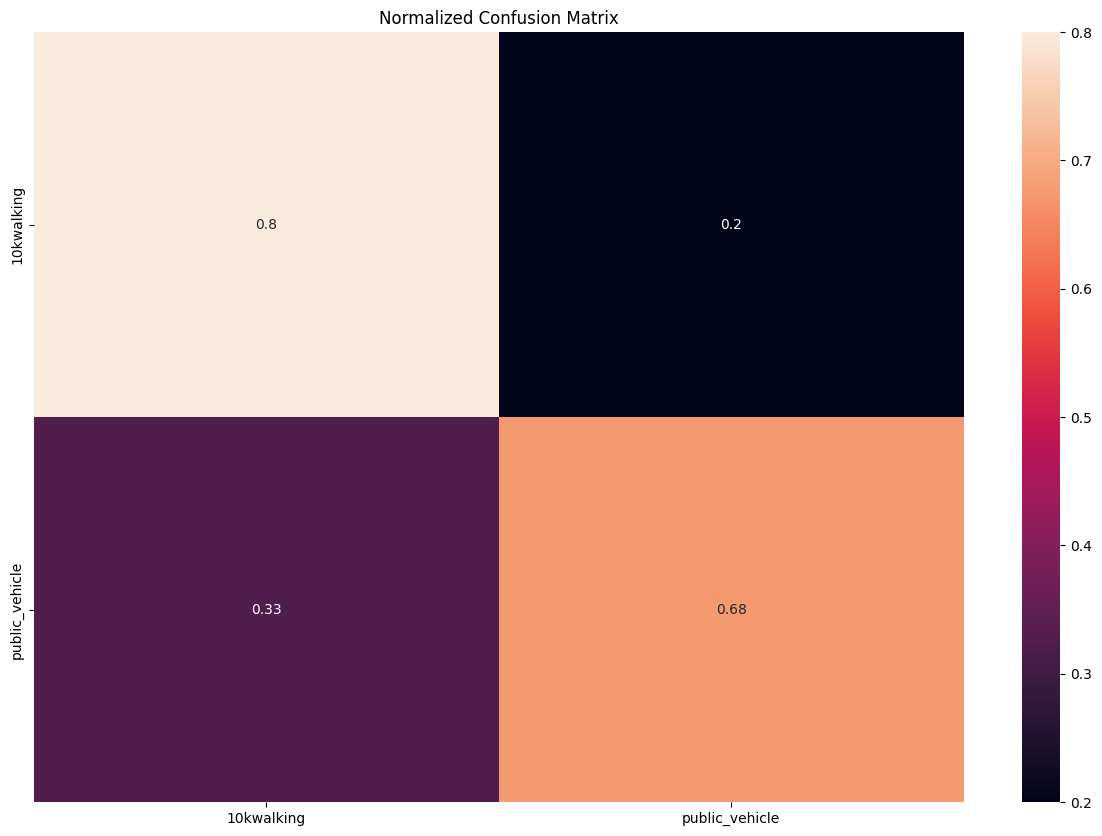

In [ ]:
import seaborn as sns

test_acc = np.sum(test.label == test.pred) / len(test)
test_matrix = confusion_matrix(test['label'], test['pred'])
epoch_f1 = f1_score(test['label'], test['pred'], average='macro')
print(f'accuracy: {test_acc:.4f}')
print(f'f1_score: {epoch_f1:.4f}')

test_matrix = confusion_matrix(test['label'], test['pred'], normalize='true')


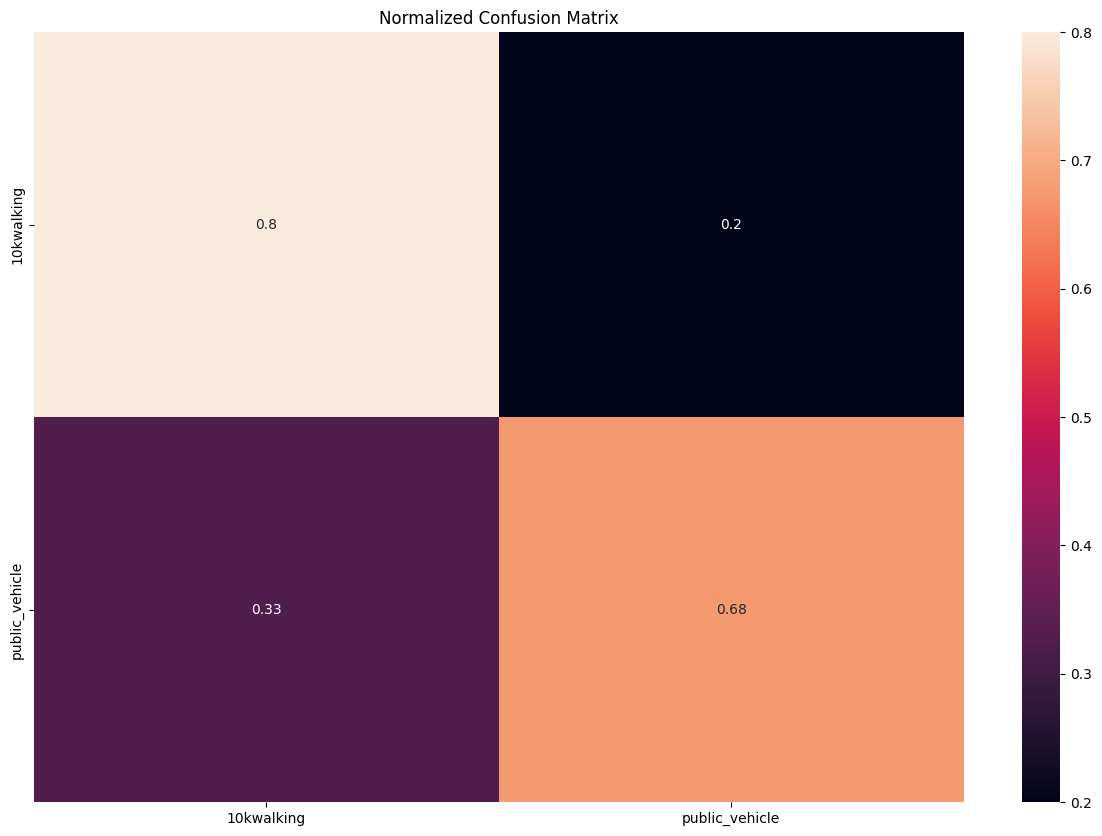

In [ ]:
test['label'] = le.inverse_transform(test['label'].values)
plt.figure(figsize = (15,10))
sns.heatmap(test_matrix, 
            annot=True, 
            xticklabels = sorted(set(test['label'])), 
            yticklabels = sorted(set(test['label'])),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

#print(f'confusion_matrix \n-------------------------\n {test_matrix}')